## setup

In [61]:
# imports and environment setup
import numpy as np
import matplotlib.pyplot as plt
# from torchinfo import summary
from tqdm import tqdm
from copy import deepcopy

import torch, timm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import v2


_ = torch.set_grad_enabled(False)

In [2]:
# common variables: device
device = torch.device(
    "mps" if torch.backends.mps.is_available() else (
    "cuda" if torch.cuda.is_available() else
    "cpu"
))

In [3]:
# utility functions
def cmp_arrays(a, b):
    if torch._is_all_true(a == b):
        print('IDENTICAL')
        return True
    else:
        for ats, at in zip(['1e-8', '1e-6', '1e-4'],[1e-8, 1e-6, 1e-4]): 
            if torch.allclose(a, b, atol=at):
                print(f'CLOSE ENOUGH (atol < {ats})')
                return True
        print(f'abs distance: {torch.dist(a, b, p=1).item()}')
        return False
    
def test_correctness(A, B, compare_fn, args=[], kwargs={}):
        a = A(*args, **kwargs)
        b = B(*args, **kwargs)
        compare_fn(a, b)

def test_speed(A, B, n, args=[], kwargs={}):
    for _ in tqdm(range(n[0])):
        A(*args, **kwargs)
    for _ in tqdm(range(n[1])):
        B(*args, **kwargs)

def get_random_sample(dataset):
    i = np.random.randint(len(dataset))
    return dataset[i][0].to(device).unsqueeze(0)

def test_model(model, dataloader):
    sm = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        acc, correct = 0, 0
        for features, labels in tqdm(iter(dataloader)):
            features = features.to(device)
            labels = labels.to(device)
            clf = sm(model(features)).argmax(1)
            correct += (clf == labels).sum()
    acc = correct / len(dataloader.dataset)
    return acc

In [ ]:
# load_model_timm, load_dataset
def load_model_timm(model_type, dataset_name, verbose=False):
    """ 
    model   types: B/16, S/16 or Ti/16
    dataset names: cifar100 or oxford-iiit-pet
    """
    import pandas as pd
    index = pd.read_csv('models/index.csv')
    pretrains = set(
        index.query('ds=="i21k"').groupby('name').apply(
        lambda df: df.sort_values('final_val').iloc[-1], 
        include_groups=False).filename
    )
    finetunes = index.loc[index.filename.apply(lambda name: name in pretrains)]
    checkpoint = (
        finetunes.query(f'name=="{model_type}" and adapt_ds=="{dataset_name}"')
        .sort_values('adapt_final_val').iloc[-1].adapt_filename
    ) # Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224
    if verbose: print(f"Loaded checkpoint: {checkpoint}")
    
    timm_modelnames = {
        'Ti/16-224': 'vit_tiny_patch16_224',
        'Ti/16-384': 'vit_tiny_patch16_384',
        'S/16-224': 'vit_small_patch16_224',
        'S/16-384': 'vit_small_patch16_384',
        'B/16-224': 'vit_base_patch16_224',
        'B/16-384': 'vit_base_patch16_384'
    }
    num_classes = 100 if dataset_name == 'cifar100' else 37
    res = int(checkpoint.split('_')[-1])
    model = timm.create_model(timm_modelnames[f'{model_type}-{res}'], num_classes=num_classes)
    
    # downloading a checkpoint automatically
    # may show an error, but still downloads the checkpoint
    from tensorflow.io import gfile # type: ignore
    if not gfile.exists(f'models/{checkpoint}.npz'):     
        gfile.copy(f'gs://vit_models/augreg/{checkpoint}.npz', f'models/{checkpoint}.npz')
    timm.models.load_checkpoint(model, f'models/{checkpoint}.npz')

    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)
    return model

def load_dataset(dataset_name, batch_size, model_cfg=None, subset_size = 1., res = (224, 224), train=False, download_dataset=False):
    """
    dataset name: cifar100 or oxford-iiit-pet
    """
    dataset = (
        datasets.CIFAR100('data/', train=train, download=download_dataset) if dataset_name == 'cifar100' 
        else datasets.OxfordIIITPet('data/', split=('trainval' if train else 'test'))
    ) 
    if model_cfg is None:
        m, s = [0.5]*3, [0.5]*3
    else:
        m, s = model_cfg['mean'], model_cfg['std']
        res = model_cfg['input_size'][-2:]
    dataset.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=m, std=s),
            v2.Resize(res),
    ])
    if subset_size < 1.0:
        n = len(dataset)
        n_small = int(subset_size * n)
        dataset, _ = random_split(dataset, [n_small, n - n_small])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataset, dataloader

## work-in-progress code

In [5]:
# svd_score reference & regular
def svd_score_reference(q, k):
    """q, k shape (batch, sequence, head, dimension)"""
    U, S, Vt = torch.linalg.svd((q @ k.mT).cpu().double())
    U, S, Vt = U.to(ref := q), S.to(ref), Vt.to(ref)
    
    U  =  U.unsqueeze(2).transpose(2, -1)
    Vt = Vt.unsqueeze(2).transpose(2, -2)
    S  =  S[..., None, None]
    svd_maps = ((U * S) @ Vt).flatten(start_dim=-2)

    q = q.unsqueeze(2).transpose(2, -1)
    k = k.unsqueeze(2).permute(0, 1, 4, 2, 3)
    att_maps = (q @ k).flatten(start_dim=-2)

    torch.divide(att_maps, att_maps.norm(dim=-1, keepdim=True), out=att_maps)
    torch.divide(svd_maps, svd_maps.norm(dim=-1, keepdim=True), out=svd_maps)
    scores = torch.einsum('bhdm,bhnm->bhd', att_maps, svd_maps)

    return scores

def svd_score(q, k):
    """q, k shape (batch, sequence, head, dimensions)"""
    _, RQ = torch.linalg.qr(q.cpu(), mode='r')
    _, RK = torch.linalg.qr(k.cpu(), mode='r')
    Ug, _, Vhg = torch.linalg.svd(RQ @ RK.mT, full_matrices=False)
    RQ, RK = RQ.to(device), RK.to(device)
    Uhg, Vhg = Ug.mT.to(device), Vhg.to(device)

    F.normalize(RQ, dim=2, out=RQ)
    F.normalize(RK, dim=2, out=RK)
    torch.matmul(Uhg, RQ, out=RQ)
    torch.matmul(Vhg, RK, out=RK)
    scores = torch.linalg.vecdot(RQ, RK)
    return scores

In [6]:
# column similarity score
def similarity_score_reference(x):
    B, _, D = x.shape
    score = torch.ones((B, D)) * D
    F.normalize(x, dim=1, out=x)
    for (d1, d2) in np.ndindex(D, D):
        score[:, d1] -= abs((x[:, :, d1] * x[:, :, d2]).sum(dim=1))
    return score

def similarity_score(x):
    '''input shape (B, N, D) - batch, sequence len, embedding dimension'''
    x = F.normalize(x, dim=1)
    score = torch.einsum('bnd,bnt->bdt', x, x)
    torch.abs(score, out=score)
    score = x.shape[-1] - score.sum(dim=-1) 
    return score

In [ ]:
# attention block with split qk & v matrices
class Attention(nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.fused_attn = attn.fused_attn
        
        self.num_heads = attn.num_heads
        self.scale = attn.scale
        # qkv.weight.shape: (num_heads * (2*qk_dim + v_dim), emb_dim)
        self.qkv = attn.qkv
        self.q_norm = attn.q_norm
        self.k_norm = attn.k_norm
        self.attn_drop = attn.attn_drop
        self.proj = attn.proj
        self.proj_drop = attn.proj_drop
        
        # previous attention class assumed 
        # that all head dims for Q, K, V are the same
        # between heads and between Q, K, V
        # this attention class doesn't assume
        # that head dims are the same between Q, K, V
        # but, still, they're the same between heads of Q, K, V
        self.qk_dim, self.v_dim = attn.head_dim, attn.head_dim
        self.split_dim = [self.num_heads*c for c in [self.qk_dim]*2+[self.v_dim]]


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, _ = x.shape
        q, k, v = torch.split(self.qkv(x), self.split_dim, dim=-1)
        # q, k, v = self.q(x), self.k(x), self.v(x)
        q = q.reshape(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        k = k.reshape(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        v = v.reshape(B, N, self.num_heads, self.v_dim).transpose(1, 2)
        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn:
            x = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_drop.p if self.training else 0.,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, self.split_dim[-1])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [ ]:
# snp class
class SNP:
    def __init__(self, attn, do_svd_scoring=True, do_sim_scoring=True):
        self.num_heads = attn.num_heads
        self.qk_dim = attn.qk_dim
        self.v_dim = attn.v_dim
        self.split_dim = attn.split_dim
        self.scale = attn.scale
        self.do_svd_scoring = do_svd_scoring
        self.do_sim_scoring = do_sim_scoring

    def __call__(self, module, inp, out):
        B, N = out.shape[:2]
        q, k, v = torch.split(out, self.split_dim, dim=-1)
        q = q.reshape(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        k = k.reshape(B, N, self.num_heads, self.qk_dim).transpose(1, 2)
        if self.do_svd_scoring:
            self.svd_scores = svd_score(q, k)
        if self.do_sim_scoring:
            self.sim_scores = similarity_score(v).reshape(B, self.num_heads, self.v_dim)

class MLP_SNP:
    def __init__(self, module, do_scoring=True):
        self.out_features = module.out_features
        self.do_scoring = do_scoring
    def __call__(self, module, inp, out):
        if self.do_scoring:
            self.sim_scores = similarity_score(out)

In [176]:
# convert_attention_blocks, register_hooks functions
def convert_attention_blocks(model):
    for i, b in enumerate(model.blocks):
        model.blocks[i].attn = Attention(b.attn)
    return model

def register_hooks(model, kwargs={}):
    for b in model.blocks:
        snp = SNP(b.attn, **kwargs)
        b.attn.qkv.register_forward_hook(snp)
        fc1, fc2 = MLP_SNP(b.mlp.fc1), MLP_SNP(b.mlp.fc2)
        b.mlp.fc1.register_forward_hook(fc1)
        b.mlp.fc1.register_forward_hook(fc2)
    return model

def remove_hooks(model):
    for b in model.blocks:
        b.attn.qkv._forward_hooks.popitem()
        b.mlp.fc1._forward_hooks.popitem()
        b.mlp.fc2._forward_hooks.popitem()
    return model

In [ ]:
def collect_scores(model, dl):
    svd_scores, sim_scores = [], []
    fc1_scores, fc2_scores = [], []
    snp_hooks, fc1_hooks, fc2_hooks = [], []
    for b in model.blocks:
        snp_hooks.append(next(iter(b.attn.qkv._forward_hooks.values())))
        fc1_hooks.append(next(iter(b.mlp.fc1._forward_hooks.values())))
        fc2_hooks.append(next(iter(b.mlp.fc2._forward_hooks.values())))
        hook = snp_hooks[-1]
        svd_scores.append(torch.zeros((hook.num_heads, hook.qk_dim), device=device))
        sim_scores.append(torch.zeros((hook.num_heads, hook.v_dim), device=device))
        hook = fc1_hooks[-1]
        fc1_scores.append(torch.zeros((hook.out_features,), device=device))
        hook = fc2_hooks[-1]
        fc2_scores.append(torch.zeros((hook.out_features,), device=device))
    
    with torch.no_grad():
        for features, _ in tqdm(dl):
            model(features.to(device))
            for i, (h1, h2, h3) in enumerate(zip(snp_hooks, fc1_hooks, fc2_hooks)):
                if hook.attn_svd:
                    svd_scores[i] += hook.svd_scores.abs().sum(0)
                if hook.attn_sim:
                    sim_scores[i] += hook.sim_scores.sum(0)

    return svd_scores, sim_scores

def zero_out_attn(model, sparsity, svd_scores, sim_scores):
    svd_list, sim_list = [], []
    for svd, sim in zip(svd_scores, sim_scores):
        svd_list.append(svd.sort().indices)
        sim_list.append(sim.sort().indices)

    for b, svd, sim in zip(model.blocks, svd_list, sim_list):
        m = b.attn
        o = m.qk_dim*m.num_heads
        ta, tb = int(m.qk_dim*sparsity[0]), int(m.v_dim*sparsity[1])
        for h in range(m.num_heads):
            ho, hvo = h * m.qk_dim, h * m.v_dim
            
            m.qkv.weight[svd[h, :ta]+ho] = 0
            m.qkv.weight[svd[h, :ta]+ho+o] = 0

            m.qkv.weight[sim[h, :tb]+2*o+hvo] = 0
            m.proj.weight[:, sim[h, :tb]+hvo] = 0
    
    return model

In [ ]:
dl = load_dataset('cifar100', 8, subset_size=.1)[1]
dl_pruning = load_dataset('cifar100', 4, subset_size=.1)[1]
model = convert_attention_blocks(load_model_timm('Ti/16', 'cifar100'))

In [ ]:
register_hooks(model, {'attn_svd':False, 'attn_sim':False})
# register_hooks(model)
svd_sc, sim_sc = collect_scores(model, dl_pruning)
remove_hooks(model)

step, n_steps = 4/64, 16
results_both, results_svd, results_sim = [0]*n_steps, [0]*n_steps, [0]*n_steps

#both
# for i in range(n_steps):
#     m = deepcopy(model)
#     zero_out_attn(m, [step*i, step*i], svd_sc, sim_sc)
#     results_both[i] = float(test_model(m, dl))
#     print(f'{results_both[i]*100:.1f}%')

# # iso-svd
# for i in range(n_steps):
#     m = deepcopy(model)
#     zero_out_attn(m, [step*i, 0], svd_sc, sim_sc)
#     results_svd[i] = float(test_model(m, dl))
#     print(f'{results_svd[i]*100:.1f}%')

# # iso-sim
for i in range(n_steps):
    m = deepcopy(model)
    zero_out_attn(m, [0, step*i], svd_sc, sim_sc)
    results_sim[i] = float(test_model(m, dl))
    print(f'{results_sim[i]*100:.1f}%')

100%|██████████| 125/125 [00:04<00:00, 25.97it/s]


88.5%


100%|██████████| 125/125 [00:04<00:00, 26.07it/s]


82.1%


100%|██████████| 125/125 [00:04<00:00, 26.16it/s]


66.1%


100%|██████████| 125/125 [00:04<00:00, 26.09it/s]


46.5%


100%|██████████| 125/125 [00:04<00:00, 26.12it/s]


35.9%


100%|██████████| 125/125 [00:04<00:00, 26.06it/s]


26.9%


100%|██████████| 125/125 [00:04<00:00, 26.18it/s]


17.1%


100%|██████████| 125/125 [00:04<00:00, 26.08it/s]


8.7%


100%|██████████| 125/125 [00:04<00:00, 26.09it/s]


6.0%


100%|██████████| 125/125 [00:04<00:00, 26.11it/s]


3.2%


100%|██████████| 125/125 [00:04<00:00, 25.98it/s]


3.1%


100%|██████████| 125/125 [00:04<00:00, 26.13it/s]


2.7%


100%|██████████| 125/125 [00:04<00:00, 26.01it/s]


3.0%


100%|██████████| 125/125 [00:04<00:00, 26.04it/s]


2.4%


100%|██████████| 125/125 [00:04<00:00, 25.96it/s]


1.2%


100%|██████████| 125/125 [00:04<00:00, 25.89it/s]


0.8%


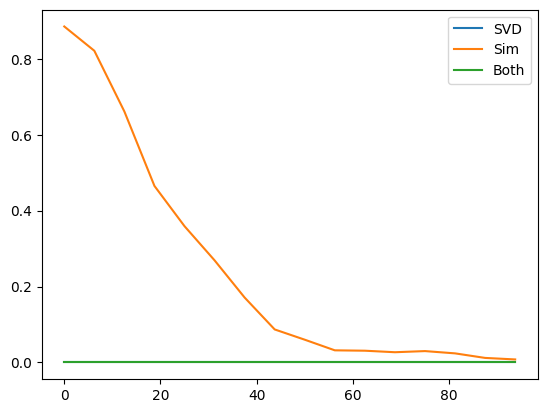

In [164]:
def show_results():
    sp = np.linspace(0, step*(n_steps-1)*100, n_steps)
    plt.plot(sp, results_svd, label='SVD')
    plt.plot(sp, results_sim, label='Sim')
    plt.plot(sp, results_both, label='Both')
    plt.legend()
    plt.show()

# sort scores ascending
show_results()

## test runs & experiments

In [151]:
# accuracy test of timm model on subset of cifar100

print(test_model(
    convert_attention_blocks(load_model_timm('Ti/16', 'cifar100')),
    load_dataset('cifar100', 8, subset_size=.25)[1]
))

100%|██████████| 313/313 [00:12<00:00, 26.01it/s]

tensor(0.8848, device='mps:0')


In [ ]:
# test correctness and speed of svd importance scoring algorithm

# test_correctness(
#     svd_score_reference, svd_score, cmp_arrays,
#     (torch.randn(4, 3, 197, 64, device=device), torch.randn(4, 3, 197, 64, device=device))
# )

# test_speed(
#     svd_score_reference, svd_score, [50, 500], 
#     (torch.randn(4, 3, 197, 64, device=device), torch.randn(4, 3, 197, 64, device=device))
# )

In [ ]:
# test correctness and speed of column similarity importance scoring

# test_correctness(similarity_score_reference, similarity_score, cmp_arrays, [torch.randn((16,16,16))])

# test_speed(similarity_score_reference, similarity_score, [4, 8000], args=[torch.randn(((4, 256, 256)))])